### Data Set Description
Describe in detail your dataset, including its source and size (both before and after
preprocessing). Clearly specify what the input and target of interest is, and the number of
examples allocated to your training, validation, and test sets.

- 104 flower types from 5 public datasets
- 5.15GB total, 7,382 image files
- CSV with image IDs and corresponding labels
- Training: 12,752 images, Validation: 3,712 images, Test: 7,382 images

### Data Preprocessing Steps
As we are using a Kaggle dataset we expected the dataset to be fairly ready for use but to verify this we performed the following preprocessing and validation steps. The use of the TFrecord format ensures that there are no missing values. To assess the presence of outliers we evaluated the range of pixel density and did not encounter any outliers. The data included 4 training, validation and test data sets for the image sizes 192x192, 224x224, 331x331 and 512x512. In order to efficiently process these data sets we combined the images to create one training, validation and test set and standardized the image dimensions to be 512x512 using RGB formatting and then normalized the features using a 0-1 range. The labels for the dataset were already given in numerical form so there was no need to convert the labels.


## Accessing the Data and Importing Libraries

To run this notebook you can access it through your Kaggle account and download the dataset, I've also added the data to a Google Drive link

Kaggle: https://www.kaggle.com/competitions/tpu-getting-started/data
Google Drive: https://drive.google.com/drive/folders/1faaLvX08juidkhuA6Z2SgQ0x1R28DgI8

Then you can clone down the github repo, add this data to the project folder and the code should run

In [1]:
%reset -f
from __future__ import print_function

import math
import seaborn as sns
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import os
import glob
import warnings
warnings.filterwarnings('ignore')


## Familiarizing the file structures and contents

In [2]:
## Checks what's in the project directory
print("Files in current directory:")
for item in os.listdir('.'):
    print(f"  {item}")

print("\n" + "="*50)

## Checks if the tpu-getting-started folder exists
if os.path.exists('./tpu-getting-started'):
    print("Contents of tpu-getting-started folder:")
    for item in os.listdir('./tpu-getting-started'):
        print(f"  {item}")
else:
    print("tpu-getting-started folder not found!")

print("\n" + "="*50)

## Searches for any .tfrec files with different patterns
all_tfrec_files = glob.glob('./**/*.tfrec*', recursive=True)
## Commented out for brevity, outputs all the .tfrec files
# print(f"All .tfrec files found: {all_tfrec_files}")

## Also searches for other common TensorFlow file extensions
tf_files = glob.glob('./**/*.tf*', recursive=True)

## Outputs all Tensorflow files
print(f"Total Number of TensorFlow-related files: {len(tf_files)}")

##Outputs all Tensorflow files and
# print(f"All TensorFlow-related files: {tf_files}")

Files in current directory:
  Preprocessing.ipynb
  .DS_Store
  tpu-getting-started
  README.md
  .virtual_documents
  .ipynb_checkpoints
  .git
  tpu-getting-started.zip

Contents of tpu-getting-started folder:
  tfrecords-jpeg-192x192
  .DS_Store
  tfrecords-jpeg-331x331
  tfrecords-jpeg-512x512
  tfrecords-jpeg-224x224
  sample_submission.csv

Total Number of TensorFlow-related files: 192


In [3]:
##Looks at the contents of each folder
folders = ['tfrecords-jpeg-192x192', 'tfrecords-jpeg-331x331', 'tfrecords-jpeg-512x512', 'tfrecords-jpeg-224x224']

for folder in folders:
    folder_path = f'./tpu-getting-started/{folder}'
    if os.path.exists(folder_path):
        print(f"\nContents of {folder}:")
        files = os.listdir(folder_path)

        ##Shows first five files
        for file in files[:5]:  
            print(f"  {file}")
        if len(files) > 5:
            print(f"  ... and {len(files) - 5} more files")
        print(f"Total files: {len(files)}")


Contents of tfrecords-jpeg-192x192:
  .DS_Store
  test
  train
  val
Total files: 4

Contents of tfrecords-jpeg-331x331:
  test
  train
  val
Total files: 3

Contents of tfrecords-jpeg-512x512:
  test
  train
  val
Total files: 3

Contents of tfrecords-jpeg-224x224:
  test
  train
  val
Total files: 3


In [4]:
## Function to return the number of each type of file in each image size folder
def check_tfrecord_files():
    """Check TFRecord files for all image sizes and return summary"""
    
    image_sizes = ['tfrecords-jpeg-192x192', 'tfrecords-jpeg-224x224', 
                   'tfrecords-jpeg-331x331', 'tfrecords-jpeg-512x512']
    
    results = {}
    
    for image_size in image_sizes:
        print(f"\n=== {image_size} ===")
        
        ## Search for files in each dataset type and image dimensions (ie: train 224x224)
        train_files = glob.glob(f'./tpu-getting-started/{image_size}/train/*.tfrec*')
        test_files = glob.glob(f'./tpu-getting-started/{image_size}/test/*.tfrec*')
        val_files = glob.glob(f'./tpu-getting-started/{image_size}/val/*.tfrec*')
        
        ## Print results
        print(f"Found {len(train_files)} training files")
        print(f"Found {len(test_files)} test files") 
        print(f"Found {len(val_files)} validation files")
        
        if train_files:
            print(f"Example train file: {train_files[0]}")
        
        ## Store results for potential return/further use
        results[image_size] = {
            'train': train_files,
            'test': test_files,
            'val': val_files
        }
    
    return results

##Call the function
file_info = check_tfrecord_files()


=== tfrecords-jpeg-192x192 ===
Found 16 training files
Found 16 test files
Found 16 validation files
Example train file: ./tpu-getting-started/tfrecords-jpeg-192x192/train/07-192x192-798.tfrec

=== tfrecords-jpeg-224x224 ===
Found 16 training files
Found 16 test files
Found 16 validation files
Example train file: ./tpu-getting-started/tfrecords-jpeg-224x224/train/09-224x224-798.tfrec

=== tfrecords-jpeg-331x331 ===
Found 16 training files
Found 16 test files
Found 16 validation files
Example train file: ./tpu-getting-started/tfrecords-jpeg-331x331/train/12-331x331-798.tfrec

=== tfrecords-jpeg-512x512 ===
Found 16 training files
Found 16 test files
Found 16 validation files
Example train file: ./tpu-getting-started/tfrecords-jpeg-512x512/train/03-512x512-798.tfrec


In [5]:
## Chooses the 224x224 image size to explore
image_size = 'tfrecords-jpeg-224x224'
train_files = glob.glob(f'./tpu-getting-started/{image_size}/train/*.tfrec*')

## Outputs the length of the training files
print(f"Working with {len(train_files)} training files")

## Examines the structure of the .tfrec file
def examine_tfrecord(filename):
    """Look at the raw structure of a TFRecord file"""
    raw_dataset = tf.data.TFRecordDataset([filename])
    
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print("TFRecord structure:")
        print(example)
        break

## Examines the first .tfrec file, commented out for brevity as it shows all the bytes in the first .tfrec which is very long, uncomment if you want to see the data
# if train_files:
#     examine_tfrecord(train_files[0])

Working with 16 training files


## Create and Standardize the Datasets

In [6]:
## Function to decode and normalize the images and standardize to RGB
## May want to consider standardizing to a different size (higher = more accuracy, lower = more efficiency)
image_size = [512,512]

def decode_image(image_data):
    """Function to decode the image from the .tfrec"""
    ## Converts the raw JPEG file bytes into a 3D tensor, channels=3  indicates RGB, create the shape (height, width, 3), the output is a uint tensor with values 0-255
    image = tf.image.decode_jpeg(image_data, channels=3)
    
    ## Resize all images to the image size specified above [512,512], using bilinear method to smooth the images for efficient processing
    image = tf.image.resize(image, image_size, method = "bilinear")
    
    ## Converts the uint to float32, then normalizes the inputs by dividing by the number of pixel values 255
    image = tf.cast(image, tf.float32) / 255.0
    
    ## Takes the image size defined above this function and reshapes it to be the image size [height, width, 3]
    image = tf.reshape(image, [*image_size,3])
    return image
    

In [7]:
## Function to return an image, label pair for the training and validation sets
def read_labeled_tfrec(input_example):
    """Read and parse the labeled .tfrec"""
    ## Tells Tensorflow how to interpret the binary .tfrec data, "image" tells TF to expect binary jppeg bytes, "class" tells TF to expect integer labels (the flower labels)
    labeled_tfrec_format = { 
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    ## Parses the input_example using the format specified above
    ## Takes raw binary data (input_example) and uses the labeled_tfrec_format to return a dictionary {image bytes, flower label}
    input_example = tf.io.parse_single_example(input_example, labeled_tfrec_format)
    
    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])
    
    ## Process the label - input_example['class'] is the flower class ID
    label = tf.cast(input_example['class'], tf.int32)
    return image, label

In [8]:
## Function to return an image without labels for the test set
def read_unlabeled_tfrec(input_example):
    """Read and parse the unlabeled .tfrec"""
    unlabeled_tfrec_format = { 
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string)
    }    
    input_example = tf.io.parse_single_example(input_example, unlabeled_tfrec_format)
    
    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])
    
    ## Process the label - input_example['id'] is the image ID
    image_id = input_example['id']
    return image, image_id

In [9]:
def load_dataset(filenames, labeled=True):
    """Load TFRecord dataset from filenames"""
    ## Creates a dataset that reads the files, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Creates a dataset of the raw binary .tfrec examples
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)

    ## dataset.map applies the read_labeled_tfrec function to each example, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Transforms the raw data to (image_tensor, label_int) pairs
    if labeled:
        dataset = dataset.map(read_labeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(read_unlabeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)       
    return dataset

In [11]:
## Combine all four image sizes into standardized datasets
image_size_folders = ['tfrecords-jpeg-192x192', 'tfrecords-jpeg-224x224', 'tfrecords-jpeg-331x331', 'tfrecords-jpeg-512x512']

## Initialize empty lists to collect all filenames from all image sizes
all_training_filenames = []
all_validation_filenames = []
all_test_filenames = []

## Collect filenames from all four image size folders
for folder in image_size_folders:
    train_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/train/*.tfrec")
    val_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/val/*.tfrec")
    test_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/test/*.tfrec")
    
    all_training_filenames.extend(train_files)
    all_validation_filenames.extend(val_files)
    all_test_filenames.extend(test_files)
    
    print(f"From {folder}:")
    print(f"  Training files: {len(train_files)}")
    print(f"  Validation files: {len(val_files)}")
    print(f"  Test files: {len(test_files)}")

print(f"\nCOMBINED TOTALS:")
print(f"Training files: {len(all_training_filenames)}")
print(f"Validation files: {len(all_validation_filenames)}")
print(f"Test files: {len(all_test_filenames)}")

## Creates standardized datasets with images from all four sizes
training_filenames = all_training_filenames
validation_filenames = all_validation_filenames
test_filenames = all_test_filenames

From tfrecords-jpeg-192x192:
  Training files: 16
  Validation files: 16
  Test files: 16
From tfrecords-jpeg-224x224:
  Training files: 16
  Validation files: 16
  Test files: 16
From tfrecords-jpeg-331x331:
  Training files: 16
  Validation files: 16
  Test files: 16
From tfrecords-jpeg-512x512:
  Training files: 16
  Validation files: 16
  Test files: 16

COMBINED TOTALS:
Training files: 64
Validation files: 64
Test files: 64


In [13]:
## Load and create the three standardized training dataset
train_dataset = load_dataset(training_filenames, labeled=True)
print(f"Training dataset created from {len(training_filenames)} files")

## Load and create the standardized validation dataset  
validation_dataset = load_dataset(validation_filenames, labeled=True)
print(f"Validation dataset created from {len(validation_filenames)} files")

## Load and create the standardized test dataset
test_dataset = load_dataset(test_filenames, labeled=False)
print(f"Test dataset created from {len(test_filenames)} files")

print(f"\nAll images will be standardized to {image_size} pixels during processing.")
print("The datasets now contain images from all four original sizes (192x192, 224x224, 331x331, 512x512) resized to a standard 512x512 size in RGB")


Training dataset created from 64 files
Validation dataset created from 64 files
Test dataset created from 64 files

All images will be standardized to [512, 512] pixels during processing.
The datasets now contain images from all four original sizes (192x192, 224x224, 331x331, 512x512) resized to a standard 512x512 size in RGB


In [14]:
## Verify the datasets by checking a few samples
print("Verifying the combined datasets...")

## Check training dataset
print("\nTraining dataset sample:")
for image, label in train_dataset.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")
    print(f"Image dtype: {image.dtype}")

## Check validation dataset  
print("\nValidation dataset sample:")
for image, label in validation_dataset.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")
    print(f"Image dtype: {image.dtype}")

## Check test dataset
print("\nTest dataset sample:")
for image, image_id in test_dataset.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Image ID: {image_id}")
    print(f"Image dtype: {image.dtype}")

print(f"\nAll datasets successfully created and standardized to {image_size} resolution!")

Verifying the combined datasets...

Training dataset sample:
Image shape: (512, 512, 3)
Label: 47
Image dtype: <dtype: 'float32'>

Validation dataset sample:
Image shape: (512, 512, 3)
Label: 13
Image dtype: <dtype: 'float32'>

Test dataset sample:
Image shape: (512, 512, 3)
Image ID: b'aeb67eefb'
Image dtype: <dtype: 'float32'>

All datasets successfully created and standardized to [512, 512] resolution!


2025-06-19 14:41:38.588032: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-06-19 14:41:38.602578: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-19 14:41:38.620459: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Looking Shape errors, Value range errors and Label errors

In [16]:
def check_dataset_quality(dataset, dataset_name, is_labeled=True):
    """
    Perform quality checks on the dataset
    
    Args:
        dataset: TensorFlow dataset to check
        dataset_name: Name of the dataset for reporting
        is_labeled: Whether the dataset has labels (True for train/val, False for test)
    """
    print(f"\n=== Checking {dataset_name} Dataset Quality ===")
    
    ## Initialize counters and statistics
    total_images = 0
    shape_errors = 0
    value_range_errors = 0
    label_errors = 0
    unique_labels = set()
    
    ## Takes a sample of images to check
    for batch in dataset.take(100): 
        total_images += 1

        ##If/else to determine the batch
        if is_labeled:
            image, label = batch
        else:
            image, _ = batch 
            
        ## Check image shape
        if image.shape != (512, 512, 3):
            shape_errors += 1
            print(f"Shape error in sample {total_images}: {image.shape}")
            
        ## Check pixel value range
        min_val = tf.reduce_min(image)
        max_val = tf.reduce_max(image)
        if min_val < 0.0 or max_val > 1.0:
            value_range_errors += 1
            print(f"Value range error in sample {total_images}: min={min_val}, max={max_val}")
            
        ## Check labels (for training and validation sets), given 104 flower labels
        if is_labeled:
            if label < 0 or label > 103:  
                label_errors += 1
                print(f"Label error in sample {total_images}: {label}")
            unique_labels.add(int(label))
    
    ## Print summary
    print(f"\nQuality Check Summary for {dataset_name}:")
    print(f"Total samples checked: {total_images}")
    print(f"Shape errors: {shape_errors}")
    print(f"Value range errors: {value_range_errors}")
    
    if is_labeled:
        print(f"Label errors: {label_errors}")
        print(f"Unique labels found: {len(unique_labels)}")
        print(f"Label coverage: {(len(unique_labels)/104)*100:.2f}% of classes")
    
    return shape_errors == 0 and value_range_errors == 0 and label_errors == 0

## Run quality checks on all datasets
print("Running comprehensive data quality checks...")

train_quality = check_dataset_quality(train_dataset, "Training", is_labeled=True)
val_quality = check_dataset_quality(validation_dataset, "Validation", is_labeled=True)
test_quality = check_dataset_quality(test_dataset, "Test", is_labeled=False)

if train_quality and val_quality and test_quality:
    print("\nAll datasets passed quality checks!")
else:
    print("\Some quality checks failed. Please review the errors above.")

Running comprehensive data quality checks...

=== Checking Training Dataset Quality ===

Quality Check Summary for Training:
Total samples checked: 100
Shape errors: 0
Value range errors: 0
Label errors: 0
Unique labels found: 47
Label coverage: 45.19% of classes

=== Checking Validation Dataset Quality ===

Quality Check Summary for Validation:
Total samples checked: 100
Shape errors: 0
Value range errors: 0
Label errors: 0
Unique labels found: 50
Label coverage: 48.08% of classes

=== Checking Test Dataset Quality ===

Quality Check Summary for Test:
Total samples checked: 100
Shape errors: 0
Value range errors: 0

All datasets passed quality checks!


2025-06-19 14:46:38.735946: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Assessing Pixel and Label Distributions

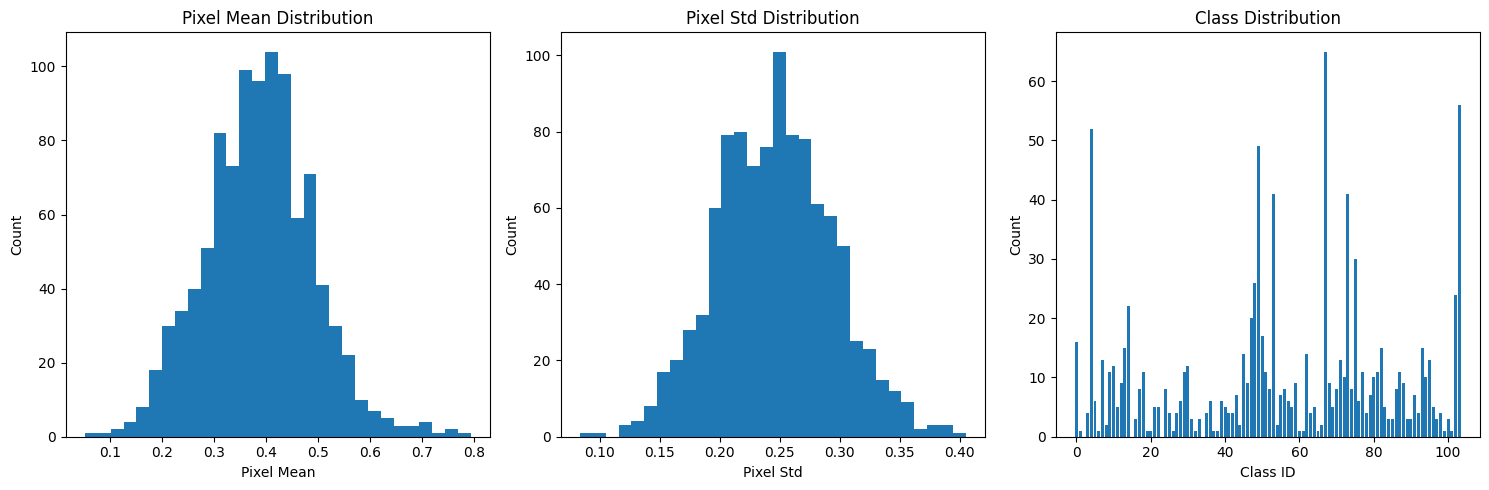


Summary Statistics:
Mean pixel value: 0.387
Std of pixel values: 0.246
Number of unique classes: 100


In [35]:
## Function to analyze the distribution of the datasets
def analyze_data_distribution(dataset, num_samples=1000):
    """
    Analyze and visualize the data distribution
    
    Args:
        dataset: TensorFlow dataset to analyze
        num_samples: Number of samples to analyze
    """    
    ## Creates empty lists to collect data
    pixel_means = []
    pixel_stds = []
    labels = []
    
    for batch in dataset.take(num_samples):
        image, label = batch
        
        ## Calculate image mean, std and label
        mean = tf.reduce_mean(image)
        std = tf.math.reduce_std(image)
        
        pixel_means.append(float(mean))
        pixel_stds.append(float(std))
        labels.append(int(label))
    
    ## Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ## Plot pixel mean distribution
    ax1.hist(pixel_means, bins=30)
    ax1.set_title('Pixel Mean Distribution')
    ax1.set_xlabel('Pixel Mean')
    ax1.set_ylabel('Count')
    
    ## Plot pixel standard deviation distribution
    ax2.hist(pixel_stds, bins=30)
    ax2.set_title('Pixel Std Distribution')
    ax2.set_xlabel('Pixel Std')
    ax2.set_ylabel('Count')
    
    ## Plot label distribution
    label_counts = pd.Series(labels).value_counts().sort_index()
    ax3.bar(label_counts.index, label_counts.values)
    ax3.set_title('Class Distribution')
    ax3.set_xlabel('Class ID')
    ax3.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    ## Print summary statistics
    print("\nSummary Statistics:")
    print(f"Mean pixel value: {np.mean(pixel_means):.3f}")
    print(f"Std of pixel values: {np.mean(pixel_stds):.3f}")
    print(f"Number of unique classes: {len(set(labels))}")

## Analyze training data distribution
analyze_data_distribution(train_dataset)

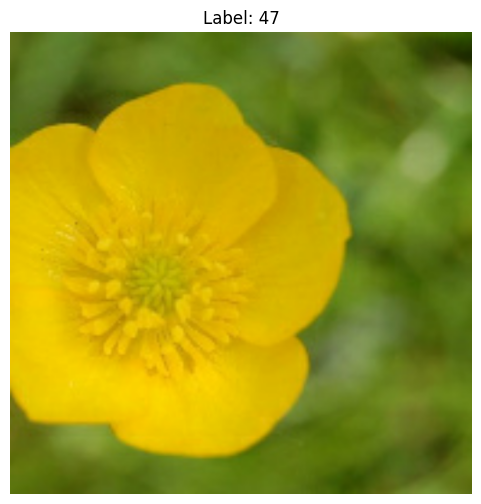

In [29]:
## Creates a function to show an image or images from the dataset (I'm visual and want to be able to see the images)
def show_image(dataset, index=0):
    """
    Display a single image from a dataset with its label
    
    Args:
        dataset: TensorFlow dataset to display image from
        index: Index of the image to display (default: 0)
    """
    ## Get the specified image
    for i, (image, label) in enumerate(dataset):
        if i == index:
            ## Convert to uint8 for display
            display_image = tf.cast(image * 255, tf.uint8)
            
            ## Show the image
            plt.figure(figsize=(6, 6))
            plt.imshow(display_image)
            plt.title(f'Label: {label}')
            plt.axis('off')
            plt.show()
            break

## Change the index here to see a specific image 
show_image(train_dataset, index=0)  

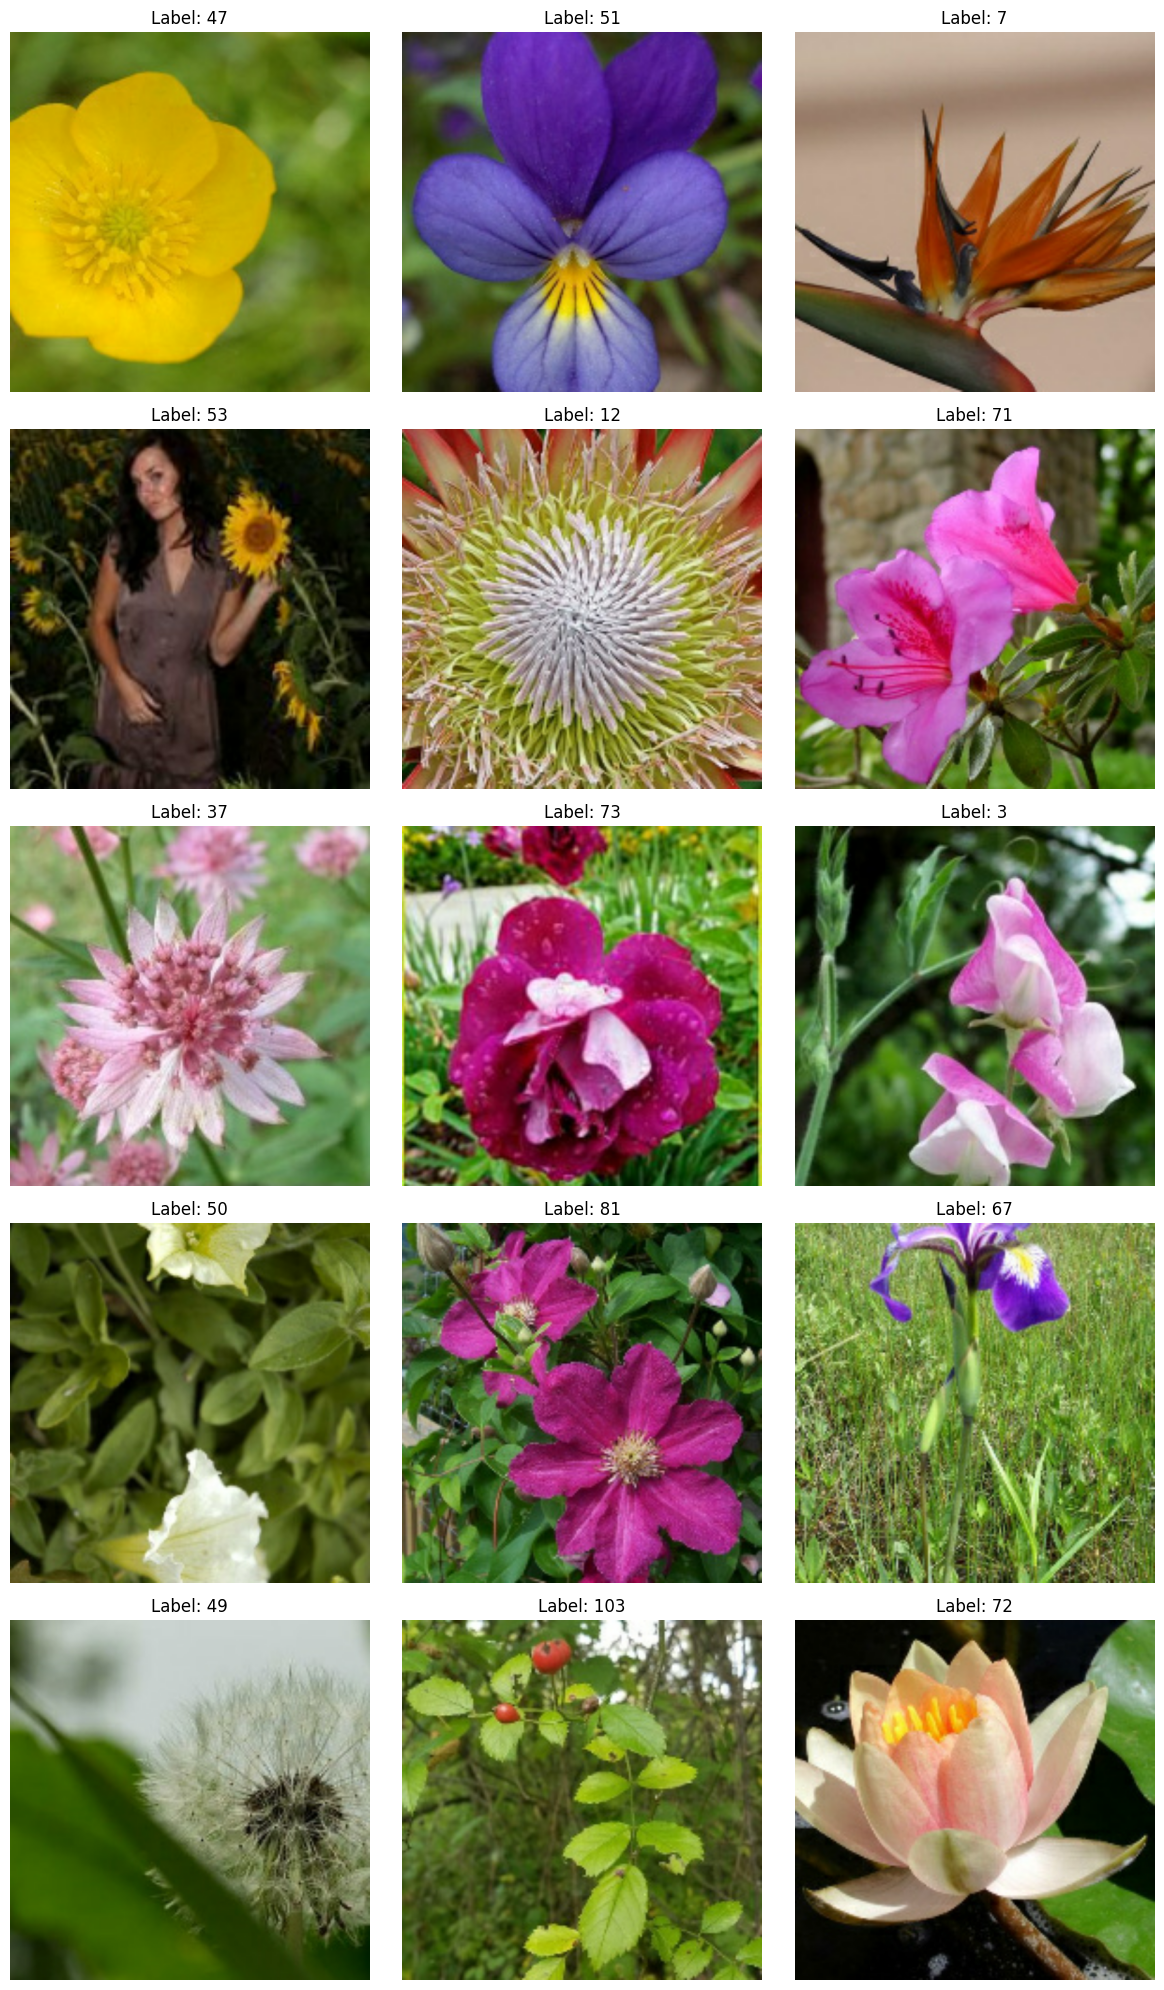

In [34]:
## Function to see a grid of a number of images in the specified dataset
def show_image_grid(dataset, start_idx=0, num_images=9, cols=3):
    """
    Display a grid of images from a dataset
    
    Args:
        dataset: TensorFlow dataset to display images from
        start_idx: Starting index (default: 0)
        num_images: Number of images to display (default: 9)
        cols: Number of columns in the grid (default: 3)
    """
    ## Calculates the number of rows needed
    rows = (num_images + cols - 1) // cols
    
    ## Creates figure
    plt.figure(figsize=(4*cols, 4*rows))
    
    ## Counter for successful image displays
    displayed = 0
    
    ## Loop through dataset
    for i, (image, label) in enumerate(dataset.skip(start_idx)):
        if displayed >= num_images:
            break
            
        ## Create Plot
        plt.subplot(rows, cols, displayed + 1)
        
        ## Convert to uint8 for display
        display_image = tf.cast(image * 255, tf.uint8)
        
        ## Show image
        plt.imshow(display_image)
        plt.title(f'Label: {label}')
        plt.axis('off')
        
        displayed += 1
    
    plt.tight_layout()
    plt.show()

##Input dataset and number of images to display, chaneg th start index
show_image_grid(train_dataset, start_idx=0, num_images=15)